In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Input, LSTM, Bidirectional, Dense, TimeDistributed, RepeatVector
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption, calculate_datetime_diffs
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
BATCH_SIZE = 2048
SEQUENCE_SIZE = 64

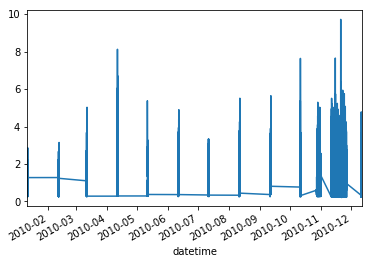

In [45]:
dataset['active_power'].plot()

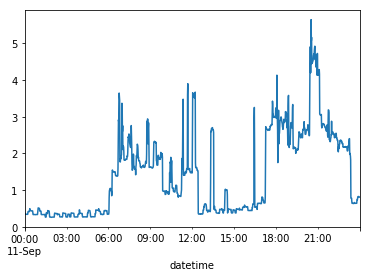

In [85]:
dataset['active_power'].loc['2010-09'].plot()

# Data

In [100]:
dataset = load_household_power_consumption(hour_one_hot=True)
dataset = dataset.loc[:'2010-09']
dataset['active_power'] = dataset['active_power'].rolling(window=16).mean()
dataset['active_power_diff1'] = dataset['active_power'].diff(-1)
dataset['active_power_diff2'] = dataset['active_power'].diff(-2)
dataset['active_power_diff3'] = dataset['active_power'].diff(-3)
dataset['active_power_diff4'] = dataset['active_power'].diff(-4)
dataset['active_power_diff5'] = dataset['active_power'].diff(-5)

dataset['active_power2'] = dataset['active_power']**2
dataset['active_power3'] = dataset['active_power']**3
dataset['active_power4'] = dataset['active_power']**4
dataset['active_power5'] = dataset['active_power']**5
dataset['active_power6'] = dataset['active_power']**6
dataset['active_power7'] = dataset['active_power']**7
dataset['active_power8'] = dataset['active_power']**8
dataset['active_power9'] = dataset['active_power']**9
dataset = dataset.dropna()

data_x, data_y = split_x_y(dataset, SEQUENCE_SIZE)
diff_x, diff_y = split_x_y(calculate_datetime_diffs(dataset), SEQUENCE_SIZE)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(
    to_timeseries(data_x, diff_x, t=SEQUENCE_SIZE), 
    to_timeseries(data_y, diff_y, t=SEQUENCE_SIZE), 
    train_ratio=0.8)

display(dataset[['active_power', 'reactive_power', 'voltage', 'intensity', 'sub1',
                 'sub2', 'sub3', 'h_0', 'h_1', 'h_23']].head())


print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print()
print('diff_x:', diff_x.shape)
print('diff_y:', diff_y.shape)
print()
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print()
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-29 09:17:20,924 [hybrid-lstm.tool | INFO] Load existing dataset


,active_power,reactive_power,voltage,intensity,sub1,sub2,sub3,h_0,h_1,h_23
datetime,,,,,,,,,,
2010-01-11 00:15:00,1.286875,0.060,246.15,5.2,0.0,0.0,0.0,1,0,0
2010-01-11 00:16:00,1.279750,0.058,246.10,5.2,0.0,0.0,1.0,1,0,0
2010-01-11 00:17:00,1.276500,0.000,246.04,5.4,0.0,0.0,1.0,1,0,0
2010-01-11 00:18:00,1.274375,0.048,246.66,5.4,0.0,0.0,0.0,1,0,0
2010-01-11 00:19:00,1.275875,0.048,246.77,5.4,0.0,0.0,1.0,1,0,0


data_x: (12876, 44)
data_y: (12876, 1)

diff_x: (12876, 1)
diff_y: (12876, 1)

train_x: (9847, 64, 44)
train_y: (9847, 64, 1)

test_x: (2462, 64, 44)
test_y: (2462, 64, 1)


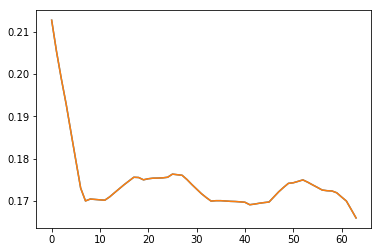

In [101]:
plot(data_x[SEQUENCE_SIZE:SEQUENCE_SIZE*2, 0])
plot(data_y[:SEQUENCE_SIZE])

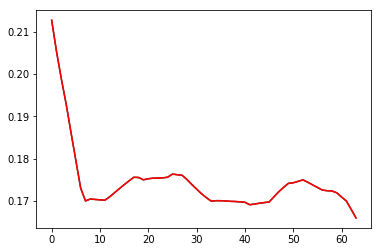

In [102]:
plot(train_x[SEQUENCE_SIZE, :, 0], color='#333333')
plot(train_y[0], color='red')

파란색 그래프가 보이면 안됩니다.
파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거


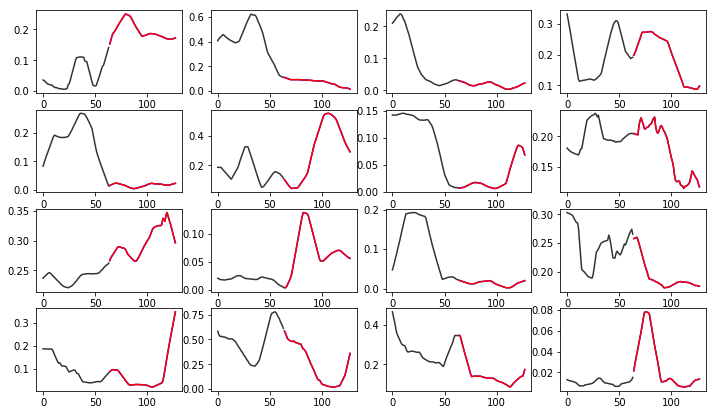

In [103]:
def vis_dataset(x, y):
    n = x.shape[0]
    seq_n = x.shape[1]
    
    fig, plots = pylab.subplots(4, 4)
    fig.set_figwidth(12)
    fig.set_figheight(7)
    plots = plots.reshape(-1)

    for p in plots:
        idx = np.random.randint(0, n)
        x1 = np.arange(seq_n)
        x2 = np.arange(seq_n, seq_n*2)
        
        p.plot(x1, x[idx, :, 0], label='input', color='#333333')
        p.plot(x2, x[idx+SEQUENCE_SIZE, :, 0], label='output', color='blue')
        p.plot(x2, y[idx, :, 0], label='output', color='red')

print('파란색 그래프가 보이면 안됩니다.')
print('파란색 그래프가 보인다는 뜻은.. 데이터 전처리가 잘못 되었다는 증거')
vis_dataset(train_x, train_y)

# Models

In [7]:
d = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2]

np.convolve(d, np.ones(4), mode='same')/4

array([ 0.75,  1.5 ,  2.5 ,  3.5 ,  4.5 ,  5.5 ,  6.5 ,  7.5 ,  8.5 ,
        7.25,  5.25])

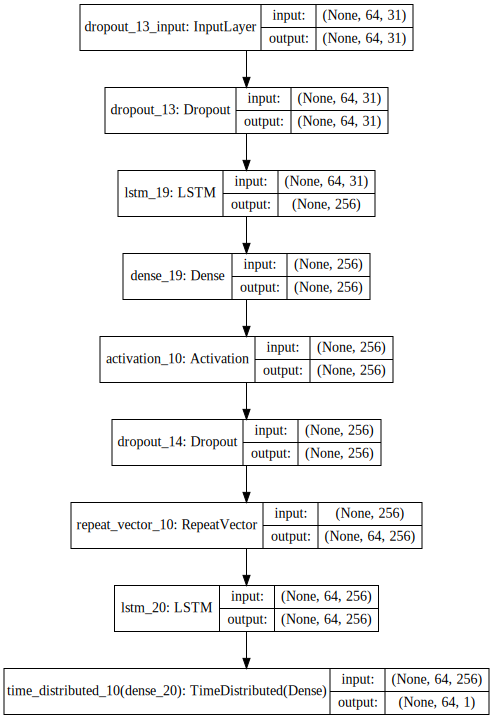

In [104]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def create_model(l1=256, d1=256, drop1=0.3, drop2=0.3, l2=256, n_input=30, n_output=64):
    np.random.seed(0)
    model = Sequential()
    
    # Encoder
    if drop1:
        model.add(Dropout(drop1, input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(LSTM(l1, input_shape=(SEQUENCE_SIZE, n_input)))
    model.add(Dense(d1))
    model.add(Activation('selu'))
    if drop2:
        model.add(Dropout(drop2))
    
    # Decoder
    model.add(RepeatVector(n_output))
    model.add(LSTM(l2, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model
    
    
model = create_model(l1=256, d1=256, l2=256, n_input=31)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [106]:
model = create_model(l1=128, d1=128, drop1=None, drop2=0.3, l2=128, n_input=44)

history = History()
model.fit(train_x, train_y, epochs=14, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 9847 samples, validate on 2462 samples
Epoch 1/14
1s - loss: 0.0348 - acc: 1.0155e-04 - r2: -6.5837e-01 - val_loss: 0.0213 - val_acc: 0.0000e+00 - val_r2: -1.9487e-01
Epoch 2/14
1s - loss: 0.0182 - acc: 1.1266e-04 - r2: 0.1468 - val_loss: 0.0106 - val_acc: 0.0000e+00 - val_r2: 0.3887
Epoch 3/14
1s - loss: 0.0144 - acc: 1.0473e-04 - r2: 0.3225 - val_loss: 0.0131 - val_acc: 0.0000e+00 - val_r2: 0.2762
Epoch 4/14
1s - loss: 0.0131 - acc: 1.0155e-04 - r2: 0.3838 - val_loss: 0.0099 - val_acc: 0.0000e+00 - val_r2: 0.4306
Epoch 5/14
1s - loss: 0.0123 - acc: 1.0473e-04 - r2: 0.4191 - val_loss: 0.0100 - val_acc: 0.0000e+00 - val_r2: 0.4391
Epoch 6/14
1s - loss: 0.0118 - acc: 1.0790e-04 - r2: 0.4430 - val_loss: 0.0090 - val_acc: 0.0000e+00 - val_r2: 0.4906
Epoch 7/14
1s - loss: 0.0113 - acc: 1.1266e-04 - r2: 0.4703 - val_loss: 0.0088 - val_acc: 0.0000e+00 - val_r2: 0.5036
Epoch 8/14
1s - loss: 0.0108 - acc: 1.1425e-04 - r2: 0.4917 - val_loss: 0.0090 - val_acc: 0.0000e+00 - val_r2: 0.493

# Evaluation

In [107]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 112 ms, sys: 12 ms, total: 124 ms
Wall time: 120 ms
loss: 0.008226779996168556
acc: 0.0
r2: 0.5309620679732167


[8473] r^2: -51.0       
[8884] r^2: -2.401      
[4581] r^2: 0.7929      
[238 ] r^2: -3.235      
[7736] r^2: -0.2858     
[2800] r^2: -0.2239     
[777 ] r^2: -233.3      
[4490] r^2: -0.61       
[3873] r^2: -2.852      
[7473] r^2: -1.875      
[6464] r^2: -0.9463     
[3340] r^2: -107.8      
[6454] r^2: -0.3777     
[4242] r^2: -0.06575    
[8383] r^2: -77.95      
[4395] r^2: -0.8402     


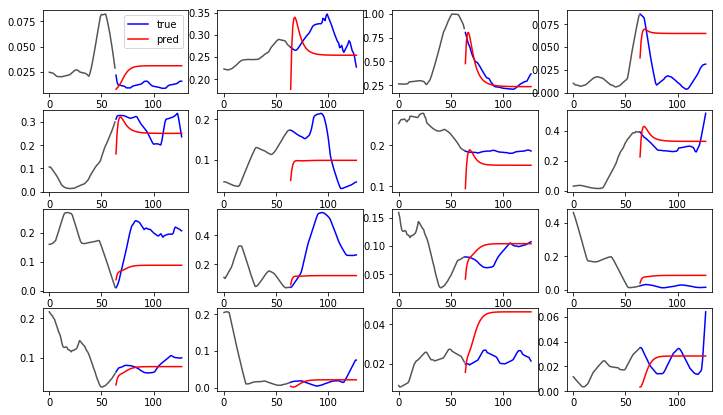

In [108]:
vis_evaluate(model, train_x, train_y, batch=2048)